# Solución de raspado web

## Paso 1: Instalar dependencias

In [3]:
pip install pandas requests

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Paso 2: Descargar HTML

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# URL de la página
url = "https://companies-market-cap-copy.vercel.app/index.html"

# Obtener el HTML de la página
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Error al acceder a la página: {response.status_code}")
html_content = response.text

html_content

'\n<!DOCTYPE html>\n<html lang="en-US">\n<head>\n<title>Tesla (TSLA) - Revenue</title>\n<meta charset="utf-8"/>\n<link rel="shortcut icon" href="https://companiesmarketcap.com/favicon.ico" type="image/x-icon">\n<link rel="apple-touch-icon" sizes="57x57" href="/img/icons/apple-icon-57x57.png">\n<link rel="apple-touch-icon" sizes="60x60" href="/img/icons/apple-icon-60x60.png">\n<link rel="apple-touch-icon" sizes="72x72" href="/img/icons/apple-icon-72x72.png">\n<link rel="apple-touch-icon" sizes="76x76" href="/img/icons/apple-icon-76x76.png">\n<link rel="apple-touch-icon" sizes="114x114" href="/img/icons/apple-icon-114x114.png">\n<link rel="apple-touch-icon" sizes="120x120" href="/img/icons/apple-icon-120x120.png">\n<link rel="apple-touch-icon" sizes="144x144" href="/img/icons/apple-icon-144x144.png">\n<link rel="apple-touch-icon" sizes="152x152" href="/img/icons/apple-icon-152x152.png">\n<link rel="apple-touch-icon" sizes="180x180" href="/img/icons/apple-icon-180x180.png">\n<link rel="ic

## Paso 3: Transformar el HTML

In [2]:
# Parsear el contenido HTML con BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

In [3]:
# Extraer la tabla de ingresos
table = soup.find("table")  

table


<table class="table" style="width:100%">
<thead>
<tr>
<th>Year</th>
<th>Revenue</th>
<th>Change</th>
</tr>
</thead>
<tbody>
<tr><td><span class="year">2024</span></td><td>$97.15 B</td><td class="percentage-green">0.39%</td></tr><tr><td><span class="year">2023</span> </td><td>$96.77 B</td><td class="percentage-green">18.8%</td></tr><tr><td><span class="year">2022</span></td><td>$81.46 B</td><td class="percentage-green">51.35%</td></tr><tr><td><span class="year">2021</span></td><td>$53.82 B</td><td class="percentage-green">70.67%</td></tr><tr><td><span class="year">2020</span></td><td>$31.53 B</td><td class="percentage-green">28.31%</td></tr><tr><td><span class="year">2019</span></td><td>$24.57 B</td><td class="percentage-green">14.52%</td></tr><tr><td><span class="year">2018</span></td><td>$21.46 B</td><td class="percentage-green">82.51%</td></tr><tr><td><span class="year">2017</span></td><td>$11.75 B</td><td class="percentage-green">67.98%</td></tr><tr><td><span class="year">2016</span

In [4]:
# Extraer las filas 

rows = table.find_all("tr")

# Procesar datos de la tabla
data = []
for row in rows[1:]:  # Saltar la fila de encabezado
    cols = row.find_all("td")
    fecha = cols[0].text.strip()
    ingresos = cols[1].text.strip()
    data.append([fecha, ingresos])

data

[['2024', '$97.15 B'],
 ['2023', '$96.77 B'],
 ['2022', '$81.46 B'],
 ['2021', '$53.82 B'],
 ['2020', '$31.53 B'],
 ['2019', '$24.57 B'],
 ['2018', '$21.46 B'],
 ['2017', '$11.75 B'],
 ['2016', '$7.00 B'],
 ['2015', '$4.04 B'],
 ['2014', '$3.19 B'],
 ['2013', '$2.01 B'],
 ['2012', '$0.41 B'],
 ['2011', '$0.20 B'],
 ['2010', '$0.11 B'],
 ['2009', '$0.11 B']]

In [5]:
# Crear un DataFrame con los datos extraídos
df = pd.DataFrame(data, columns=["Fecha", "Ingresos"])

# Ordenar los datos por la columna "Fecha" de menor a mayor 
df = df.sort_values("Fecha")

df

,Fecha,Ingresos
15,2009,$0.11 B
14,2010,$0.11 B
13,2011,$0.20 B
12,2012,$0.41 B
11,2013,$2.01 B
10,2014,$3.19 B
9,2015,$4.04 B
8,2016,$7.00 B
7,2017,$11.75 B
6,2018,$21.46 B


## Paso 4: Procesar el marco de datos

In [6]:
# Limpiar y convertir los ingresos a números
def convertir_ingresos(valor):
    if "B" in valor:
        editar_valor = float(valor.replace("B", "").replace("$", "").replace(",", ""))
        return editar_valor


df["Ingresos"] = df["Ingresos"].apply(convertir_ingresos)

df["Ingresos"]

15     0.11
14     0.11
13     0.20
12     0.41
11     2.01
10     3.19
9      4.04
8      7.00
7     11.75
6     21.46
5     24.57
4     31.53
3     53.82
2     81.46
1     96.77
0     97.15
Name: Ingresos, dtype: float64

## Paso 5: almacenar los datos en sqlite

In [7]:
# Conectar a SQLite y guardar los datos
conn = sqlite3.connect("tesla_revenues.db")
cursor = conn.cursor()

In [8]:
# Crear tabla en SQLite
cursor.execute("""
CREATE TABLE IF NOT EXISTS ingresos (
    fecha TEXT,
    ingresos REAL
)
""")

In [9]:
# Insertar datos en la base de datos
for index, row in df.iterrows():
    cursor.execute("INSERT INTO ingresos (fecha, ingresos) VALUES (?, ?)", (row["Fecha"], row["Ingresos"]))

conn.commit()
conn.close()

## Paso 6: Visualiza los datos

### Visualización de series de tiempo

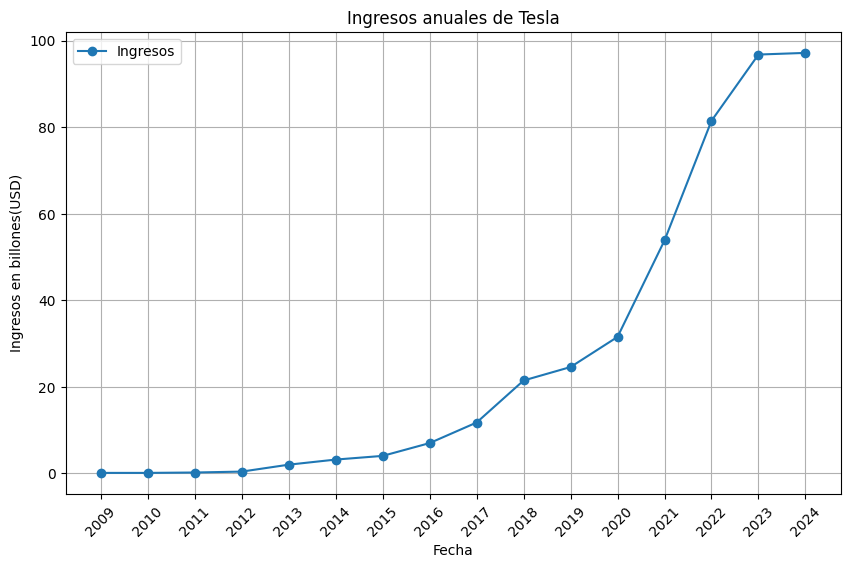

In [10]:
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(df["Fecha"], df["Ingresos"], marker='o', label="Ingresos")
plt.title("Ingresos anuales de Tesla")
plt.xlabel("Fecha")
plt.ylabel("Ingresos en billones(USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Guardar y mostrar el gráfico
plt.savefig("revenue_plot.png")
plt.show()


## Extra 

Con las librerías utilizadas anteriormente extrae las ganancias del último año de Tesla desde la siguiente URL https://companies-market-cap-copy.vercel.app/earnings.html

Nota: En esta ocasión, hemos optado por escribir todo el código como un único bloque.  Así es como se vería en un archivo de Python en lugar de un Notebook de Jupyter.

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL objetivo
url = "https://companies-market-cap-copy.vercel.app/earnings.html"

# Hacer la solicitud a la página
response = requests.get(url)
response.raise_for_status() 

# Analizar el contenido HTML
html = BeautifulSoup(response.text, "html.parser")

#Extraer la tabla de ganancias anuales
table = html.find("table", {"class": "table"}) 
rows = table.find_all("tr")[1:] 

# Extraer datos y convertirlos en listas
data = []
for row in rows:
    columns = row.find_all("td")
    year = columns[0].text.strip() 
    earnings = columns[1].text.strip()  
    data.append({"Año": year, "Ganancias": earnings})

# Crear un DataFrame con los datos
df = pd.DataFrame(data)

# Convertir ganancias a valores numéricos
def parse_earnings(value):
    try:
        value = value.replace(",", "").replace("$", "").strip()
        if "Billion" in value: 
            return float(value.replace("Billion", "")) * 1_000_000_000
        elif "Million" in value:
            return float(value.replace("Million", "")) * 1_000_000_000
        elif "M" in value:  
            return float(value.replace("M", "")) * 1_000_000
        elif "B" in value:
            return float(value.replace("B", "")) * 1_000_000_000
        else:
            return float(value)
    except ValueError:
        print(f"Advertencia: No se pudo convertir el valor '{value}'. Estableciendo como NaN.")
        return float("nan") 

# Limpiar la columna "Año"
def clean_year(value):
    try:
        return int(value.split()[0]) 
    except ValueError:
        print(f"Advertencia: No se pudo procesar el valor del año '{value}'. Estableciendo como NaN.")
        return float("nan")  

df["Ganancias"] = df["Ganancias"].apply(parse_earnings)
df["Año"] = df["Año"].apply(clean_year)

df = df.sort_values("Año", ascending=False)

# Obtener la fila del año más reciente y sus ganancias
ultimo_ano_fila = df.iloc[0]  

# Extraer el año específico de esa fila
ultimo_ano = int(ultimo_ano_fila["Año"])

mensaje = f"Tesla ha generado ${ultimo_ano_fila['Ganancias']:,.2f} de ganancias en el año {ultimo_ano}."

# Mostrar el resultado
print(mensaje)

Tesla ha generado $8,730,000,000.00 de ganancias en el año 2024.
